# Voice Activity Detection


In this notebook we will attempt implement a voice activity detection system for our assistant. This will be used to detect chunks of audio where there is speech present, so that we only run speech transcription on these important segments. We will try a thresholding approach first and see how it performs.


## Threshold Approach

For this approach we wil first preprocess the signal to contain just human speech frequencies.
We will then calibrate based on the background noise to determine an energy threshold to use.
Then we will determine if speech is present by seeing if the energy in a window is above the threshold.


## Setup

In [1]:
from glob import glob
from IPython import display as ipd
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from textgrids import TextGrid
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

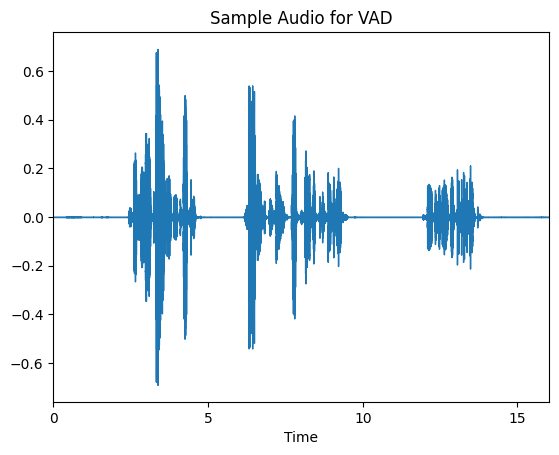

In [2]:
sample_audio, sample_rate = librosa.load('vad.wav')
librosa.display.waveplot(sample_audio)
plt.title('Sample Audio for VAD')
plt.show()
ipd.display(ipd.Audio(sample_audio, rate=sample_rate))

### Utility Functions

In [3]:
def bandpass_filter(signal_data, lowcut, highcut, sample_rate):
    """
    Apply band-pass filter to signal data.
    
    Args:
        signal_data (np.ndarray): Input audio signal data.
        lowcut (float): Lower cutoff frequency for band-pass filter.
        highcut (float): Upper cutoff frequency for band-pass filter.
        sample_rate (int): Sampling frequency of the signal data.
        
    Returns:
        filtered_data (np.ndarray): Filtered signal data.
    """
    # Normalize cutoff frequencies
    low = lowcut / (sample_rate / 2)
    high = highcut / (sample_rate / 2)

    # Design Butterworth band-pass filter
    b, a = butter(1, [low, high], btype='band')

    # Apply filter to signal data
    filtered_data = filtfilt(b, a, signal_data)

    return filtered_data

## Simple Energy Thresholding Approach

In [4]:
def energy_thresholding(signal_data, threshold, window_size, overlap_ratio, sample_rate):
    """
    Voice activity detection using energy thresholding.

    Args:
        signal_data (np.ndarray): Input audio signal data.
        threshold (float): Energy threshold for speech detection.
        window_size (int): Size of the windows for energy calculation (in samples).
        overlap_ratio (float): Overlap ratio for windowing (0 to 1).
        sample_rate (int): Sampling rate of the signal data.

    Returns:
        voice_activity (list): List of binary values (0 or 1) representing voice activity (0 for silence, 1 for speech).
    """
    # Define human speech frequency range
    lowcut = 100
    highcut = 3200

    # Apply band-pass filter to signal data
    filtered_data = bandpass_filter(signal_data, lowcut, highcut, sample_rate)

    # Calculate energy of filtered signal data
    window = np.hamming(window_size)
    hop_length = int(window_size * (1 - overlap_ratio))
    energy = np.array([
        np.sum(window * filtered_data[i:i + window_size] ** 2)
        for i in range(0, len(filtered_data) - window_size, hop_length)
    ])

    # Calculate total energy
    total_energy = np.array([
        np.sum(window * signal_data[i:i + window_size] ** 2)
        for i in range(0, len(signal_data) - window_size, hop_length)
    ])

    energy_ratio = energy / total_energy
    voice_activity = []

    # Compare energy ratio with threshold
    for i in range(len(energy_ratio)):
        if energy_ratio[i] > threshold:
            voice_activity.append(1)  # Speech
        else:
            voice_activity.append(0)  # Silent pause

    return voice_activity, energy_ratio

In [5]:
overlap_rate = 0.8
threshold = 0.7
voice_activity, energy_ratio = energy_thresholding(sample_audio, threshold, sample_rate // 10, overlap_rate, sample_rate)

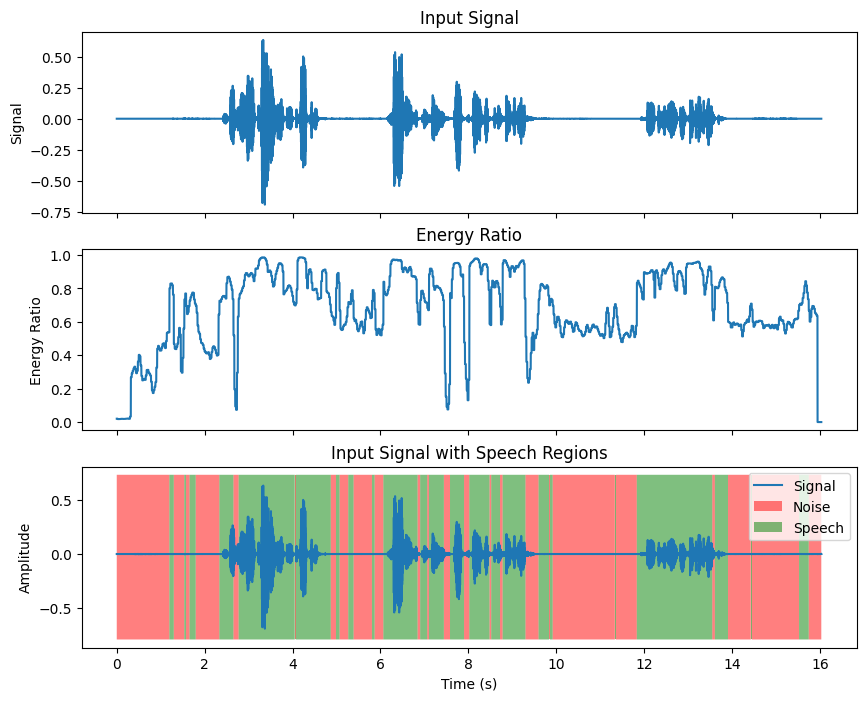

In [6]:
# Generate time axis for plotting
time = np.linspace(0, len(sample_audio) / sample_rate, num=len(sample_audio))

# Create figure and axes
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot input signal
ax[0].plot(time, sample_audio)
ax[0].set_ylabel('Signal')
ax[0].set_title('Input Signal')

# Plot energy ratio
# Energy is windowed, so spread it across the length of the signal

signal_length_ratio = np.zeros(len(sample_audio))
window_size = sample_rate // 10
overlap_size = int(window_size * (1 - overlap_rate))

for i, window_ratio in enumerate(energy_ratio):
    start = i * overlap_size
    end = i * overlap_size + overlap_size
    signal_length_ratio[start:end] = window_ratio

ax[1].plot(time, np.array(signal_length_ratio))
ax[1].set_ylabel('Energy Ratio')
ax[1].set_title('Energy Ratio')


# Plot voice activity
# Voice Activiyy is windowed, so spread it across the length of the signal

signal_length_activity = np.zeros(len(sample_audio))

for i, window_activity in enumerate(voice_activity):
    start = i * overlap_size
    end = i * overlap_size + overlap_size
    signal_length_activity[start:end] = window_activity
# Coloured signal with the speech detection results
ax[2].plot(time, sample_audio, label='Signal')
ax[2].fill_between(
    time, 
    np.min(sample_audio) - 0.1,
    np.max(sample_audio) + 0.1,
    where=signal_length_activity==0,
    facecolor='red',
    alpha=0.5,
    label='Noise'
)
ax[2].fill_between(
    time,
    np.min(sample_audio) - 0.1,
    np.max(sample_audio) + 0.1,
    where=signal_length_activity==1,
    facecolor='green',
    alpha=0.5,
    label='Speech',
)

ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Amplitude')
ax[2].set_title('Input Signal with Speech Regions')
ax[2].legend()
# Show plot
plt.show()

It seems like the simple energy thresholding approach is pretty good, it does fall down a little bit when there is background noise, however for the most part it's detecting correctly. We should be able to overcome the outliers by adding a check for consecutive windows, i.e. detecting speech in of windows, so only counting it as speech if there are two speech windows in a row. We can do the same for detecting silence after speech.


## Gaussian Mixture Model (GMM)

A more advanced way to perform voice activity detection would be to use a GMM. For this we will to train a model on data which I found on Kaggle: https://www.kaggle.com/datasets/lazyrac00n/speech-activity-detection-datasets.

GMMs are clustering models, meaning they do not require labelled data. This data is labelled, so it will be interesting to see how it performs relatvie to a classfier.

For the GMM we will extract the following features:
- Short Term Energy
- Mel-Frequency Cepstral Coefficients (MFCCs)
- Zero Crossing Rate (ZCR)

*To run this section of the notebook, you will have to download the kaggle data and extract it in this direcory.*

In [7]:
def get_annotation_filename(audio_fname):
    return audio_fname.replace('Audio', 'Annotation').replace('.wav', '.TextGrid')


def parse_annotation(annotation_fname, sample_rate):
    grid = TextGrid(annotation_fname)
    signal_labels = np.zeros(int(grid.xmax * sample_rate) + 1)
    for interval in grid['silences']:
        start = int(interval.xmin * sample_rate)
        end = int(interval.xmax * sample_rate)
        signal_labels[start:end] = int(interval.text)
    return signal_labels


audio_files = glob('Data/Audio/*/*/*.wav')

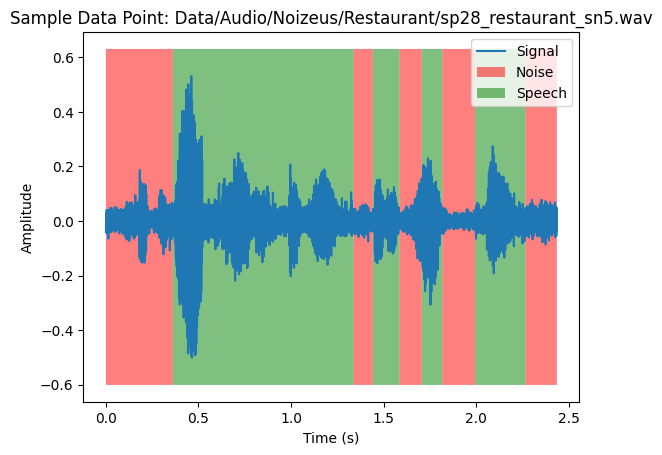

In [8]:
test_audio, test_sample_rate = librosa.load(audio_files[0])
ipd.display(ipd.Audio(test_audio, rate=test_sample_rate))

labels = parse_annotation(get_annotation_filename(audio_files[0]), test_sample_rate)


# Generate time axis for plotting
time = np.linspace(0, len(test_audio) / test_sample_rate, num=len(test_audio))

plt.plot(time, test_audio, label='Signal')
plt.fill_between(
    time, 
    np.min(test_audio) - 0.1,
    np.max(test_audio) + 0.1,
    where=labels==0,
    facecolor='red',
    alpha=0.5,
    label='Noise'
)
plt.fill_between(
    time,
    np.min(test_audio) - 0.1,
    np.max(test_audio) + 0.1,
    where=labels==1,
    facecolor='green',
    alpha=0.5,
    label='Speech'
)
plt.legend()
plt.title(f'Sample Data Point: {audio_files[0]}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [9]:
def extract_features(y, sr):
    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    # Extract zero crossing rate (ZCR)
    zcr = librosa.feature.zero_crossing_rate(y)

    # Extract short-term energy (STE)
    ste = librosa.feature.rms(y)
    
    # Extract pitch using autocorrelation
    autocorr = np.correlate(y, y, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    peaks, _ = find_peaks(autocorr)
    pitch = sr / peaks[0] if peaks.size > 0 else 0


    # Concatenate features
    features = np.concatenate([
        mfcc.flatten(),
        zcr.flatten(),
        ste.flatten(),
        pitch.flatten(),
    ])
    return features

extract_features(test_audio[:4000], test_sample_rate).shape

(177,)

In [10]:
def build_dataset(audio_fnames, window_size=4000):
    features = []
    labels = []
    for audio_fname in tqdm(audio_fnames):
        audio, sr = librosa.load(audio_fname)
        annotation = parse_annotation(get_annotation_filename(audio_fname), sr)
        for i in range(0, len(audio), window_size):
            segment = audio[i:i + window_size]
            if len(segment) < window_size:
                continue
            
            features.append(extract_features(segment, sr))
            
            labels.append(int(sum(annotation[i:i + window_size]) > window_size // 2))
    return np.array(features), np.array(labels)

X, y = build_dataset(audio_files)

  0%|          | 0/719 [00:00<?, ?it/s]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)

GaussianMixture(n_components=2)

In [26]:
from sklearn.metrics import accuracy_score

expected = y_test
actual = gmm.predict(X_test)

cl0_acc = accuracy_score(np.abs(1 - expected), actual)
cl1_acc = accuracy_score(expected, actual)

if cl0_acc > cl1_acc:
    print(f'Cluster 0 is Speech, accuracy: {cl0_acc * 100:.4}%')
else:
    print(f'Cluster 1 is Speech, accuracy: {cl1_acc * 100:.4}%')

Cluster 0 is Speech, accuracy: 74.35%


## GBM Classifier

Let's also try an Gradient Boosting Classifier on the data and then compare the three methods

In [14]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [15]:
expected = y_test
actual = xgbc.predict(X_test)

accuracy_score(expected, actual)

0.9122652582159625

The classifier seems to perform much better than the GMM. Let's try and compare the three approaches to determine the best solution.

## Basic Thresholding Accuracy



In [16]:
threshold = 0.7
overlap_ratio = 0.8
window_size = test_sample_rate // 10
overlap_size = int(window_size * (1 - overlap_rate))

preds = []
labels = []
for audio_fname in tqdm(audio_files):
    audio, sr = librosa.load(audio_fname)
    window_results, energy_ratio = energy_thresholding(audio, threshold, window_size, overlap_ratio, sr)
    annotations = parse_annotation(get_annotation_filename(audio_fname), sr)
    
    signal_length_activity = np.zeros(len(sample_audio))
    for i, window_activity in enumerate(window_results):
        start = i * overlap_size
        end = i * overlap_size + overlap_size
        signal_length_activity[start:end] = window_activity
    
    # Convert into batches of 4000 so we can compare against the test set
    for i in range(0, len(signal_length_activity), 4000):
        segment = signal_length_activity[i:i + 4000]
        annotation_segment = annotations[i:i + 4000]
        if len(segment) < 4000:
            continue
        
        if np.sum(segment) > 2000:
            preds.append(1)
        else:
            preds.append(0)
        
        if np.sum(annotation_segment) > 2000:
            labels.append(1)
        else:
            labels.append(0)

accuracy_score(np.array(labels), np.array(preds))

  0%|          | 0/719 [00:00<?, ?it/s]

0.9398786192944747

So after all that it looks like the basic energy approach is the best. The are even more advanced ways of performing voice activity detection, such as by using deep learning models, however, the performance hit from using them, particularly if not on GPU would hamper the performance of the application. Therefore, we should just stick with the basic approach.

In [17]:
xgbc.save_model('xgb_voice_activity_detection')

In [30]:
import os

os.mkdir(f'{gmm_name}')
gmm_name = 'gmm_voice_activity_detection'
np.save(f'{gmm_name}/weights', gmm.weights_, allow_pickle=False)
np.save(f'{gmm_name}/means', gmm.means_, allow_pickle=False)
np.save(f'{gmm_name}/covariances', gmm.covariances_, allow_pickle=False)

if cl0_acc > cl1_acc:
    np.save(f'{gmm_name}/speech_cluster', np.int8(0), allow_pickle=False)
else:
    np.save(f'{gmm_name}/speech_cluster', np.int8(1), allow_pickle=False)